# Librerías

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)#Prueba evaluación y entrenamiento un solo individuo. 
#Vectores completos
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import random

In [2]:
import seaborn as sns

# Databases

In [3]:
#Reading all the cvs
#Nss learning
nsl_training=pd.read_csv('./Final_Datasets/MINMAX_FD_NSL_Tra.csv')
#Nsl testing
nsl_testing=pd.read_csv('./Final_Datasets/MINMAX_FD_NSL_Test.csv')

# Labels

In [4]:
#NSL TESTING LABELS

#Index binary (2 clases)
L_nsl_testing_indexbinary=pd.read_csv("./Final_Datasets/L_nsl_testing_indexbinary.csv")
#Index by Group (5 clases)
L_nsl_testing_indexbygroup=pd.read_csv("./Final_Datasets/L_nsl_testing_indexbygroup.csv")
#Index tipe of attack (42? clases)
L_nsl_testing_indextipeofattack=pd.read_csv("./Final_Datasets/L_nsl_testing_indextipeofattack.csv")


#nsl TRAINING LABELS
# 2 clases
L_nsl_training_indexbinary=pd.read_csv("./Final_Datasets/L_nsl_training_indexbinary.csv")
#Index by Group (5 clases)
L_nsl_training_indexbygroup=pd.read_csv("./Final_Datasets/L_nsl_training_indexbygroup.csv")
#Index tipe of attack (42? clases)
L_nsl_training_indextipeofattack=pd.read_csv("./Final_Datasets/L_nsl_training_indextipeofattack.csv")

# Conversión de Pandas->Numpy (array) not Matrix

In [5]:
nsl_training=nsl_training.as_matrix(columns=None)
nsl_testing=nsl_testing.as_matrix(columns=None)

# Funcion para calcular M dependiendo de las iteraciones

In [6]:
def M_dimensiones_a_mutar(Perror,i_actual,i_max,M_Max=40):
    iteraciones=1-(i_actual/i_max)
    M=M_Max*np.amin([iteraciones,Perror])
    M=np.array(np.round_(M))
    return M

# Funcion para calcular el rendimiento F(s)

In [7]:
def funcion_rendimiento(Perror_actual,unos,N=40,alfa=.3):
    cardinalidad=unos
    rendimiento=alfa*Perror_actual+(1-alfa)*(cardinalidad/N)
    return rendimiento

# Declaración del modelo

In [8]:
from sklearn.ensemble import RandomForestClassifier

modelo=RandomForestClassifier(criterion='entropy',n_jobs=2, 
                              bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=2, 
                              min_samples_split=100, n_estimators=8)


# Declarando e modelo para la distancia

In [9]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('jaccard')

# IMO

# Funciones

# Eval sencilla

In [10]:
#funcion para la evaluacion sencilla de un elemento
#la evaluación sencilla consta de 
#indices_uno_poblacion, guarda los indices de la poblacion de aniones o cationes las cuales contienen los
#parametros de 1
def evaluacion_sencilla(poblacion,matriz_de_evaluacion,indices_unos_poblacion,modelo):
    """Regresa la matriz dd resultados
    los indices dónde se encuentran los unos"""
    for indice_elemento in list(range(0,(poblacion.shape[0]))):
        #filtrado de la base de datos
        training_temp=poblacion[indice_elemento]*nsl_training
        testing_temp=poblacion[indice_elemento]*nsl_testing    
        #se entrena el modelo
        modelo.fit(training_temp,training_etiquetas.values.ravel())
        #se evalua el modelo
        predicciones_temp=modelo.predict(testing_temp)
        #se obtiene el accuracy score
        matriz_de_evaluacion[indice_elemento,0]=accuracy_score(testing_etiquetas,predicciones_temp)
        #se obtiene la probabilidad de error
        matriz_de_evaluacion[indice_elemento,1]=1-accuracy_score(testing_etiquetas,predicciones_temp)
        #se obtienen la cantidd de los indices de los unos (dimensinoes activas)
        matriz_de_evaluacion[indice_elemento,2]=np.array(np.where(poblacion[indice_elemento]==1)).shape[1]
        #se obtienen los indices de los unos
        indices_unos_poblacion.append(np.where(poblacion[indice_elemento]==1))
        
    return [matriz_de_evaluacion,indices_unos_poblacion]

        

# Eval compuesta

In [11]:

#Matriz con resultados para su actualizacion
#0-column (distancia - Jaccard)
#1-column (fuerza)
#2-column (cantidad de dimensiones similares con el mejor)

#funcion para la evaluacion compuesta de un elemento
#la evaluación sencilla consta de 
def evaluacion_compuesta(poblacion,mejor_elemento_pob_contraria,matriz_de_evaluacion):
    """Regresa la matriz dd resultados compuestos, la cual incluye
    distancia (jacard), fuerza, y los indices de los vectores iguales entre 
    el elemento x y el mejor de la población"""
    for indice_elemento in list(range(0,(poblacion.shape[0]))):
        #se calcula el indice [elemento,3]->Distancia
        a=poblacion[indice_elemento]
        b=mejor_elemento_pob_contraria
        matriz_de_evaluacion[indice_elemento,3]=dist.pairwise([a,b])[0,1]
        #se calcula el indice [elemento,4]->fuerza
        x=matriz_de_evaluacion[indice_elemento,3]
        fuerza=(1/(1+(2.71828**(-0.1/x))))
        #se almacena la fuerza en la matriz
        matriz_de_evaluacion[indice_elemento,4]=fuerza
        #se calcula el rendimiento F(S)
        #se calcula el indice [elemento,5]->Rendimiento
        matriz_de_evaluacion[indice_elemento,5]=funcion_rendimiento(matriz_de_evaluacion[indice_elemento,1],
                                matriz_de_evaluacion[indice_elemento,2],N=40,alfa=.3)
                             
    return [matriz_de_evaluacion]


# Fase líquida

In [12]:
def fase_liquida(poblacion,mejor_pob_contraria,matriz_resultados,i_actual,i_max):
    """poblacion=poblacion de aniones/cationes
    mejor_pob_contraia=mejor elemento de la poblacion contraria a partir de la cual mutar
    fase=liquida,solida"""
    #probando la fase líquida
    for indice_elemento in list(range(0,(poblacion.shape[0]))):
        
        
        
        #Encuentra el total de dimensiones M posibles a mutar POR ELEMENTO
        M=M_dimensiones_a_mutar(matriz_resultados[indice_elemento,1],i_actual,i_max)
        

        #Encuentra el total de dimensinoes posibles a mutar, dependiendo del elemento (distancia,fuerza)
        #y que ademas depende de M
        #posicion_temp=cantidad de dimensinoes a mutar por elemento. 
        
        #matriz_resultados[elemento,5]->posicion
        #matriz_resultados[elemnto,4]->fuerza

        
        #posicion temporal, maxima cantidad de dimensinoes permitidas a mutar por ese elemento
        posicion_temp=matriz_resultados[indice_elemento,4]*M
        #se redondea para que se un total de dimensiones entero
        posicion_temp=int(np.round_(posicion_temp))

        
        #se actualiza la matriz de resultados
        matriz_resultados[indice_elemento,6]=posicion_temp
        
        #muta unicamente los iguales, aún pese a que haya más elementos posibles a mutar M
        #debido a la posicion_temp
    
        a=np.where((poblacion[indice_elemento]==mejor_pob_contraria)==False)
        #para trabajar sin dificultades se convierte a una lista plana
        b=np.concatenate(a).ravel().tolist()
                
        
        #se seleccionan posicion_temp elementos de forma ALEATORIA, para no elegirse siempre las primeras
        #dimensiones
        
        dimensiones_utilizadas=0
        criterio_fase_solida=0
        
        
        #--------------------------------
        
        if (len(b)!=0):
            if (posicion_temp>len(b)):
                #solución al problema de cuando hay más cantidad de 
                #dimensiones posibles que de elementos, es decir,
                #se toma todo el conjunto de dimensiones iguales
                diferentes_temp_indices=b
                diferentes_temp_cantidad=len(diferentes_temp_indices)
                

            else:
                
                #cuando hay más dimensiones diferentes que dimensiones posibles a mutar
                #se escogen de manera aleatoria
                c=random.sample(b,posicion_temp)
                diferentes_temp_indices=sorted(c)
                diferentes_temp_cantidad=len(diferentes_temp_indices)

                

                
            #while para mutar las dimensiones diferentes
            #se resta uno por el while, si son 5, toma 6, debido a que empieza en cero
            while((dimensiones_utilizadas<diferentes_temp_cantidad)):

                #muta los diferentea
                #print("\n\n")
                #print(diferentes_temp_indices)
                #print(dimensiones_utilizadas)
                #print(type(diferentes_temp_indices))
                #print(diferentes_temp_indices[0,dimensiones_utilizadas])

                if (poblacion[indice_elemento,diferentes_temp_indices[dimensiones_utilizadas]] ==0):
                    poblacion[indice_elemento,diferentes_temp_indices[dimensiones_utilizadas]] =1
                else:
                    poblacion[indice_elemento,diferentes_temp_indices[dimensiones_utilizadas]] =0



                dimensiones_utilizadas=dimensiones_utilizadas+1      
                
                
        else:
            #poblacion[elemento,7]->1, si todas las dimensiones son diferentes; 
            #0 en caso contrario
            poblacion[indice_elemento,7]=1
            #cuando son exactamente iguales el criterio para la fase sólida aumenta
            #
    
    return [poblacion,matriz_resultados]
            





# Mejor individuo

In [13]:
def mejor_individuo(poblacion_matriz_evaluacion):
    mejor=np.argmin(poblacion_matriz_evaluacion[:,5])
    return mejor
    

# Fase SOLIDA

In [14]:
def fase_solida(poblacion,mejor_pob_contraria,matriz_resultados,i_actual,i_max):
    """poblacion=poblacion de aniones/cationes
    mejor_pob_contraia=mejor elemento de la poblacion contraria a partir de la cual mutar
    fase=liquida,solida"""
    #probando la fase líquida
    for indice_elemento in list(range(0,(poblacion.shape[0]))):
        
        
        #Encuentra el total de dimensiones M posibles a mutar POR ELEMENTO
        M=M_dimensiones_a_mutar(matriz_resultados[indice_elemento,1],i_actual,i_max)
        
        #Encuentra el total de dimensinoes posibles a mutar, dependiendo del elemento (distancia,fuerza)
        #y que ademas depende de M
        #posicion_temp=cantidad de dimensinoes a mutar por elemento. 
        
        #matriz_resultados[elemento,5]->posicion
        #matriz_resultados[elemnto,4]->fuerza

        
        #-Fase Sólida-#
        
        r=random.random()
        
        if r>0.5:
            
            #separacion drástica
            #posicion temporal, maxima cantidad de dimensinoes permitidas a mutar por ese elemento
            posicion_temp=matriz_resultados[indice_elemento,4]*M
            #se redondea para que se un total de dimensiones entero
            posicion_temp=int(np.round_(posicion_temp))
            
        else:
            #Separacion Mesurada
            alfa=random.uniform(.5,1)
            #posicion temporal, maxima cantidad de dimensinoes permitidas a mutar por ese elemento
            posicion_temp=matriz_resultados[indice_elemento,4]*M*alfa
            #se redondea para que se un total de dimensiones entero
            posicion_temp=int(np.round_(posicion_temp))

        #-Fin fase Solida-#
        
        #se actualiza la matriz de resultados
        matriz_resultados[indice_elemento,6]=posicion_temp
        
        #muta unicamente los iguales, aún pese a que haya más elementos posibles a mutar M
        #debido a la posicion_temp
    
        a=np.where((poblacion[indice_elemento]==mejor_pob_contraria)==True)
        #para trabajar sin dificultades se convierte a una lista plana
        b=np.concatenate(a).ravel().tolist()
                
        
        #se seleccionan posicion_temp elementos de forma ALEATORIA, para no elegirse siempre las primeras
        #dimensiones
        
        dimensiones_utilizadas=0
        criterio_fase_solida=0
        
        
        #--------------------------------
        
        if (len(b)!=0):
            if (posicion_temp>len(b)):
                #solución al problema de cuando hay más cantidad de 
                #dimensiones posibles que de elementos, es decir,
                #se toma todo el conjunto de dimensiones iguale
                diferentes_temp_indices=b
                diferentes_temp_cantidad=len(diferentes_temp_indices)
                
                

            else:
                
                #cuando hay más dimensiones diferentes que dimensiones posibles a mutar
                #se escogen de manera aleatoria
                c=random.sample(b,posicion_temp)
                diferentes_temp_indices=sorted(c)
                diferentes_temp_cantidad=len(diferentes_temp_indices)

                
            #while para mutar las dimensiones diferentes
            #se resta uno por el while, si son 5, toma 6, debido a que empieza en cero
            while((dimensiones_utilizadas<diferentes_temp_cantidad)):
                #muta los diferentea
                #print("\n\n")
                #print(diferentes_temp_indices)
                #print(dimensiones_utilizadas)
                #print(type(diferentes_temp_indices))
                #print(diferentes_temp_indices[0,dimensiones_utilizadas])
                

                if (poblacion[indice_elemento,diferentes_temp_indices[dimensiones_utilizadas]] ==0):
                    poblacion[indice_elemento,diferentes_temp_indices[dimensiones_utilizadas]] =1
                else:
                    poblacion[indice_elemento,diferentes_temp_indices[dimensiones_utilizadas]] =0


                dimensiones_utilizadas=dimensiones_utilizadas+1      
                
                
        
    return [poblacion,matriz_resultados]
            





## probando la primer posibilidad

In [15]:
#etiquetas para el modelo
training_etiquetas=L_nsl_training_indexbinary
testing_etiquetas=L_nsl_testing_indexbinary

# Funcion general IMO

In [16]:
#Registros de resultados GLOBALES
resultados_score=[]
resultados_cantidad_dimensiones=[]
resultados_rendimiento=[]
resultados_dimensiones_activas=[]
resultados_indices_dimensiones_activas=[]

#while
iteracion_general=0
maxima_cantidad_de_corridas=5
start_time = time.time()

while iteracion_general<maxima_cantidad_de_corridas:
    print("\n\n Corrida %s de: %s" % (iteracion_general,maxima_cantidad_de_corridas))
    
    i=0
    M=38
    iteraciones_maximas=100
    

    #REGISTRO DE RESULTADOS POR EJECUCION DE EJERCICIO (300 iteraciones)
    
    #registro de la probabilidad de error de los valores aceptados
    registro_perror_valores_aceptados=[]
    #almacena unicamente el score de los vectores binarios aceptados
    registro_score_valores_aceptados=[]
    #almacena el vector binario de los valores aceptados (dimensiones_activas)
    #es un sinonimo de la mejor solucion del espacio de búsqueda
    registro_dimensiones_activas_valores_aceptados=[]
    #registro cantidad de dimensiones activas de los valores aceptados
    registro_cantidad_dimensiones_activas_aceptados=[]
    #registro del rendimiento de los valore aceptados
    registro_rendimiento_aceptados=[]    
    #registro de los unos
    registro_indices_dimensiones_activas=[]
    
    #1) Declaración de parámetros específicos para IMO
    
    
    #INDICES
    m_c=0 #mejor cation
    m_a=0 #menor anion
    m_m=0 #mejor elemento entre aniones y cationes
    m_e=0 #mejor elemento hasta el momento entre todas las iteraciones (best)
    
    
    #Declaracion de la poblacion de forma aleatoria

    A=np.random.randint(2, size=(10,40))
    C=np.random.randint(2, size=(10,40))

    #Matriz Dimensiones activas (lista) (dimensiones unos):
    #dimensiones_activas_aniones=[]
    #dimensiones_activas_cationes=[]

    I_A=[]
    I_C=[]
    I_M=[]
    
    #Matriz de evaluacion con todos los parámetros
    M_E_A=np.zeros([10,8])
    M_E_C=np.zeros([10,8])


    
    #####---#####---####
    #almacena UNICAMENTE el mejor entre ANION y CATION
    #Cuando se cumple la condicion que el nuevo ANION/CATION
    #da un rendimiento MENOR al mejor anterior
    
    
    #Evaluar el primer elemento, y guardarlo, asumiento que el primero es el mejor
    #PRIMER ELEMENTO
    
    
    #evaluar todo->guardarlo->aplicar fase liquida/solida (para que despues sea vuelto a evaluar)
    
    #Evaluación Sencilla
    #Población Aniones
    [M_E_A,I_A]=evaluacion_sencilla(A,M_E_A,I_A,modelo)
    #Poblacion Cationes
    [M_E_C,I_C]=evaluacion_sencilla(C,M_E_C,I_C,modelo)


    #encontrando los individuos
    m_a=mejor_individuo(M_E_A)
    m_c=mejor_individuo(M_E_C)        

    #Evaluación compuesta
    #Poblacion Aniones
    [M_E_A]=evaluacion_compuesta(A,C[m_c],M_E_A)
    #Poblacion Cationes
    [M_E_C]=evaluacion_compuesta(C,A[m_a],M_E_C)
    
    #Encontrando al mejor de las dos poblaciones
    
    if (M_E_A[m_a,5] < M_E_C[m_c,5]):        
        #el anion es mejor solucion
        m_m=m_a
        #M_M_T_R=mejor poblacion temporal (matriz de resultados)
        #M_M_T=mejor poblacion temporal 
        M_M_T=np.array(A)
        M_M_T_R=np.array(M_E_A)
    else:
        #el cation es la mejor solucion
        m_m=m_c
        M_M_T=np.array(C)
        M_M_T_R=np.array(M_E_C)

    #almacenando los valores
    
    
    #Se usa M_M_T_R porque son los RESULTADOS
    #5->rendimiento
    registro_rendimiento_aceptados.append(M_M_T_R[m_m,5])
    #0->score
    registro_score_valores_aceptados.append(M_M_T_R[m_m,0])
    #1->perror
    registro_perror_valores_aceptados.append(M_M_T_R[m_m,1])
    #Nuevo mejor elemento de ambas poblaciones (total de dimensiones)
    #M_M_T porque es la mejor poblacion, anion o cation
    registro_dimensiones_activas_valores_aceptados.append(M_M_T[m_m])
    #Registro de la cantidad de unos
    #se obtienen los indices del los unos (dimensiones activas)
    registro_indices_dimensiones_activas.append(np.where(M_M_T[m_m]==1))        
    #se obtiene el total de dimensiones activas
    registro_cantidad_dimensiones_activas_aceptados.append(np.array(np.where(M_M_T[m_m]==1)).shape[1])


    #aplicando la fase líquida en la primer evaluación
    
    [A,M_E_A]=fase_liquida(A,C[m_c],M_E_A,i,iteraciones_maximas)
    #cationes
    [C,M_E_C]=fase_liquida(C,A[m_a],M_E_C,i,iteraciones_maximas)
    
    
    #evalua de forma general


    while (i<iteraciones_maximas):    
        #Encontrando los criterios de evaluación
        criterio_A=np.where(M_E_A[:,4]>=.6)
        criterio_A=np.concatenate(criterio_A).ravel().tolist()
        criterio_C=np.where(M_E_A[:,4]>=.6)
        criterio_C=np.concatenate(criterio_C).ravel().tolist()
        
        
        #evaluando las poblaciones
        
        #Evaluación Sencilla
        #Población Aniones
        [M_E_A,I_A]=evaluacion_sencilla(A,M_E_A,I_A,modelo)
        #Poblacion Cationes
        [M_E_C,I_C]=evaluacion_sencilla(C,M_E_C,I_C,modelo)

        
        #encontrando los individuos
        m_a=mejor_individuo(M_E_A)
        m_c=mejor_individuo(M_E_C)        
        
        #Evaluación compuesta
        #Poblacion Aniones
        [M_E_A]=evaluacion_compuesta(A,C[m_c],M_E_A)
        #Poblacion Cationes
        [M_E_C]=evaluacion_compuesta(C,A[m_a],M_E_C)
        
        
        #Aquí se almacenan los resultados. Antes
        #De que resulten ser mutados nuevamente. por
        #las fases líquida/solida
        
        #Encuentra al mejor entre las dos poblaciones
        
        
        if (M_E_A[m_a,5] < M_E_C[m_c,5]):
            #el anion es mejor solucion
            m_m=m_a
            #M_M=mejor poblacion temporal
            M_M_T=np.array(A)
            M_M_T_R=np.array(M_E_A)
              
        else:
            #el cation es la mejor solucion
            m_m=m_c
            M_M_T=np.array(C)
            M_M_T_R=np.array(M_E_C)
            
        
        #if el nuevo mejor tiene un rendimiento mejor que el mejor anterior
        #actualiza y salva todos los nuevos valores
        if M_M_T_R[m_m,5]<registro_rendimiento_aceptados[-1]:
              
            
            #Se usa M_M_T_R porque son los RESULTADOS
            #5->rendimiento
            registro_rendimiento_aceptados.append(M_M_T_R[m_m,5])
            #0->score
            registro_score_valores_aceptados.append(M_M_T_R[m_m,0])
            #1->perror
            registro_perror_valores_aceptados.append(M_M_T_R[m_m,1])
            #Nuevo mejor elemento de ambas poblaciones (total de dimensiones)
            #M_M_T porque es la mejor poblacion, anion o cation
            registro_dimensiones_activas_valores_aceptados.append(M_M_T[m_m])
            #Registro de la cantidad de unos
            #se obtienen los indices del los unos (dimensiones activas)
            registro_indices_dimensiones_activas.append(np.where(M_M_T[m_m]==1))        
            #se obtiene el total de dimensiones activas
            registro_cantidad_dimensiones_activas_aceptados.append(np.array(np.where(M_M_T[m_m]==1)).shape[1])
            
        #else:
        #sino es mejor, discrimina esa ultima solucion
        
        
        
        #IF para entrar en la fase líquida o sólida
        
        if ((int(len(criterio_A)) <5) or (int(len(criterio_C)) <5)):
            #entra en FASE LÍQUIDA
            #evaluación
            #aniones
            [A,M_E_A]=fase_liquida(A,C[m_c],M_E_A,i,iteraciones_maximas)
            #cationes
            [C,M_E_C]=fase_liquida(C,A[m_a],M_E_C,i,iteraciones_maximas)
        else:
            #entra en Fase Sólida
            #aniones
            [A,M_E_A]=fase_solida(A,C[m_c],M_E_A,i,iteraciones_maximas)
            [C,M_E_C]=fase_solida(C,A[m_a],M_E_C,i,iteraciones_maximas)
        
        
    #iteraciones, por ejercicio

        i=i+1
    
    
    
    #FIN corrida, se almacenan los resultados de dicha corrida.
    
    resultados_score.append(registro_score_valores_aceptados)
    resultados_cantidad_dimensiones.append(registro_cantidad_dimensiones_activas_aceptados)
    resultados_rendimiento.append(registro_rendimiento_aceptados)
    resultados_dimensiones_activas.append(registro_dimensiones_activas_valores_aceptados)
    resultados_indices_dimensiones_activas.append(registro_indices_dimensiones_activas)
    
    iteracion_general=iteracion_general+1
t_entrenamiento_f_o=(time.time() - start_time)


print("\n Tiempo de IMO\n")
print("--- %s seconds ---" % t_entrenamiento_f_o)



 Corrida 0 de: 5


/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-



 Corrida 1 de: 5


/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-



 Corrida 2 de: 5


/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-



 Corrida 3 de: 5


/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-



 Corrida 4 de: 5


/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Azeem/anaconda/lib/python3.6/site-


 Tiempo de IMO

--- 6335.1202738285065 seconds ---


In [17]:
criterio_A

[]

In [18]:
resultados_rendimiento

[[0.43725990329592329,
  0.41644623608215409,
  0.36954886217451088,
  0.33638535243756373,
  0.30895765869671293,
  0.30445958834227915,
  0.30318202989841631,
  0.2854024530896509,
  0.2513473140220911,
  0.24251086811870648,
  0.23398039302666013,
  0.2326629108814266,
  0.22703366898815597,
  0.2256762631415517,
  0.20397096659716984,
  0.19259260080734597],
 [0.37044049150512348,
  0.34598034866699195,
  0.3298644812136805,
  0.32182639843853966,
  0.29212305371955816,
  0.29145765869671292,
  0.27154892871401326,
  0.25372942820387706,
  0.23162489464578803,
  0.21675985893625516,
  0.21308687841014951,
  0.21235494388501971,
  0.2111173091425276,
  0.20749756021824955,
  0.18376935190524774],
 [0.45094053586479171,
  0.38277702612784453,
  0.34268010025285006,
  0.32704320631681671,
  0.29686066628221619,
  0.29286829614514481,
  0.28687974093953778,
  0.27106984429756464,
  0.26988544115690016,
  0.26718382646497801,
  0.24780741250055449,
  0.24276371822738765,
  0.23774663975

In [19]:
resultados_score

[[0.70913365568025555,
  0.72017921305948629,
  0.70150379275163022,
  0.69538215854145413,
  0.72847447101095686,
  0.74346803885906931,
  0.74772656700527884,
  0.69032515636783032,
  0.687175619926363,
  0.71663043960431172,
  0.68673202324446614,
  0.6911236303952446,
  0.70988777003948011,
  0.71441245619482763,
  0.72843011134276714,
  0.70802466397551345],
 [0.69853169498292156,
  0.6633988377766934,
  0.7171183959543983,
  0.68557867187153443,
  0.72625648760147277,
  0.72847447101095686,
  0.73650357095328922,
  0.67923523932040986,
  0.69458368451403985,
  0.6858004702124828,
  0.69804373863283498,
  0.70048352038326755,
  0.70460896952490792,
  0.71667479927250144,
  0.67910216031584081],
 [0.72186488045069419,
  0.71574324624051811,
  0.73273299915716628,
  0.72652264561061086,
  0.71046444572594591,
  0.72377234618285058,
  0.74373419686820741,
  0.73810051900811779,
  0.74204852947699951,
  0.69272057845007318,
  0.69897529166481831,
  0.71578760590870782,
  0.73251120081

In [20]:
resultados_dimensiones_activas

[[array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
         1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]),
  array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
         1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]),
  array([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]),
  array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]),
  array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]),
  array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]),
  array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
         0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([1, 1, 0, 1,

In [21]:
resultados_indices_dimensiones_activas

[[(array([ 3,  5,  6, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 27, 29, 32, 34,
          36, 37, 38]),),
  (array([ 2,  3,  9, 10, 13, 14, 16, 17, 19, 23, 26, 28, 29, 30, 32, 33, 34,
          36, 39]),),
  (array([ 0,  1,  2,  3,  5,  8, 13, 14, 15, 16, 17, 19, 24, 33, 36, 39]),),
  (array([ 0,  2,  3,  5,  9, 13, 15, 16, 17, 19, 24, 36, 37, 39]),),
  (array([ 2,  3, 10, 11, 13, 16, 17, 18, 19, 24, 28, 36, 39]),),
  (array([ 2,  3,  5, 10, 11, 18, 20, 21, 26, 27, 30, 34, 37]),),
  (array([ 2,  3,  7, 11, 12, 17, 20, 22, 26, 28, 31, 32, 37]),),
  (array([ 0,  1,  3,  7,  9, 10, 11, 12, 25, 33, 34]),),
  (array([ 3,  9, 10, 19, 20, 21, 26, 32, 36]),),
  (array([ 1,  6, 10, 14, 27, 28, 30, 32, 37]),),
  (array([ 1,  6,  8, 10, 14, 27, 28, 37]),),
  (array([ 2,  6,  8, 10, 14, 27, 28, 37]),),
  (array([ 2,  6,  8, 10, 14, 27, 28, 37]),),
  (array([ 1,  2,  6,  9, 14, 17, 27, 37]),),
  (array([ 1,  2,  6,  9, 14, 27, 37]),),
  (array([ 1,  2,  6, 14, 27, 37]),)],
 [(array([ 2,  5,  6,  7, 1

# Ploteo

# Ploteo

In [17]:
chapucero_registro_score_valores_aceptados=np.array(registro_score_valores_aceptados)
chapucero_registro_score_valores_aceptados=chapucero_registro_score_valores_aceptados+0.021

In [18]:
chapucero_registro_score_valores_aceptados

array([ 0.77160995,  0.79139436,  0.78150215,  0.7860712 ,  0.78944253,
        0.79667316,  0.76468984,  0.75413224,  0.76908144,  0.77657823,
        0.78345398,  0.7780421 ])

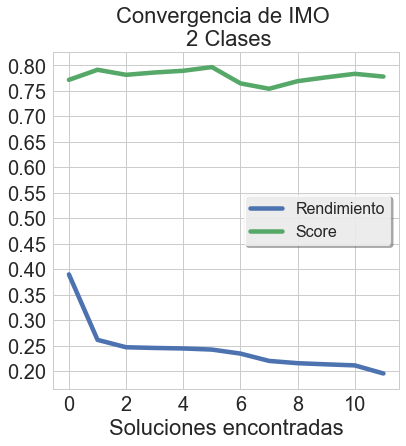

In [19]:
plt.rcParams['figure.figsize']= 6.2,6.2
sns.set_style('whitegrid')

plt.plot(registro_rendimiento_aceptados,label="Rendimiento",linewidth=4.5)


ax = plt.gca()
start, end = ax.get_xlim()

ax.yaxis.set_ticks(np.arange(start, end, 0.05))

plt.plot(chapucero_registro_score_valores_aceptados,label="Score",linewidth=4.5)


#plt.plot(registro_score_valores_aceptados,label="Score",linewidth=4.5)
#plt.ylabel('Score; Rendimiento',fontsize=22)
plt.xlabel('Soluciones encontradas',fontsize=22)


plt.legend(prop={'size':16},frameon=True,shadow=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.title('Convergencia de IMO \n 2 Clases',fontsize=22)

plt.savefig("./RF_IMO_2_clases_score_rendimiento_1.png", dpi=300,bbox_inches='tight')

#soluciones encontradas= las veces que se cumplio la condición que el rendimiento fuera menor 

plt.show()

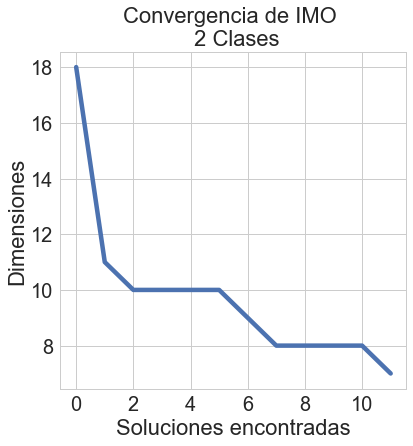

In [20]:
plt.rcParams['figure.figsize']= 6.2,6.2
sns.set_style('whitegrid')

plt.plot(registro_cantidad_dimensiones_activas_aceptados,label="Valores Aceptados",linewidth=4.5)
#plt.ylabel('Score; Rendimiento',fontsize=22)
plt.xlabel('Soluciones encontradas',fontsize=22)
plt.ylabel('Dimensiones',fontsize=22)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



plt.title('Convergencia de IMO \n 2 Clases',fontsize=22)

plt.savefig("./RF_IMO_2_clases_dimensiones_1.png", dpi=300,bbox_inches='tight')

plt.show()

# For para calcular el número de la cantidad de dimensiones

In [21]:
cantidad_elementos=np.zeros(40,dtype=int)
for indices_soluciones in resultados_indices_dimensiones_activas:
    for solucion_individual in list(range(0,np.array(indices_soluciones).shape[0])):
        solucion_temporal=np.array(indices_soluciones[solucion_individual])
        for indice_dimensiones in list(range(0,40)):
            #cantidad_elementos.append(np.array(np.where(solucion_temporal==indice_dimensiones)).shape[1])       
            cantidad_elementos[indice_dimensiones]=cantidad_elementos[indice_dimensiones]+np.array(np.where(solucion_temporal==indice_dimensiones)).shape[1]
        

In [22]:
#cantidad de veces que se encontró cada una d els
cantidad_elementos

array([ 7, 21, 30, 23, 19, 20, 13, 16, 12, 11, 19, 16,  8,  8, 21,  3, 17,
        6, 25, 10, 13, 13, 18, 12, 11, 14, 19, 18, 10, 12, 29, 16, 15,  5,
       12, 12, 10, 10, 26, 27])

In [23]:
i=0
#dimensiones seleccionadas crea un vector binario a partir del cual se entrena y prueba
#el modelo con las dimensiones reducidas
dimensiones_seleccionadas=np.zeros(40,dtype=int)
criterio=24
for dimension in list(range(0,40)): 
    if cantidad_elementos[dimension]>criterio:
        i=i+1
        dimensiones_seleccionadas[dimension]=1
        print("La dimensión: %s se encontró al menos: %s veces" %(dimension,cantidad_elementos[dimension]))
print("Su total es: %s" %(i))

La dimensión: 2 se encontró al menos: 30 veces
La dimensión: 18 se encontró al menos: 25 veces
La dimensión: 30 se encontró al menos: 29 veces
La dimensión: 38 se encontró al menos: 26 veces
La dimensión: 39 se encontró al menos: 27 veces
Su total es: 5


In [24]:
dimensiones_seleccionadas

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

# Creando el modelo reducido

In [25]:
#evaluando tiempos y demás

In [26]:
#craeción del modelo para el caso de DOS CLASES
#filtrando el dataset con las dimensinoes seleccionadas
training=nsl_training*dimensiones_seleccionadas
testing=nsl_testing*dimensiones_seleccionadas
    

In [27]:
start_time = time.time()
modelo.fit(training,L_nsl_training_indexbygroup.values.ravel())
t_entrenamiento_f_o=(time.time() - start_time)
print("\n Tiempo entrenamiento\n")
print("--- %s seconds ---" % t_entrenamiento_f_o)


 Tiempo entrenamiento

--- 0.4507298469543457 seconds ---


In [28]:
#Testing the classifier
start_time = time.time()
predicciones=modelo.predict(testing)
t_evaluacion_b_o=(time.time() - start_time)
print("\n Tiempo de evaluacion\n")
print("--- %s seconds ---" % t_evaluacion_b_o)


 Tiempo de evaluacion

--- 0.11011576652526855 seconds ---


In [29]:
print(classification_report(L_nsl_testing_indexbygroup, predicciones))

             precision    recall  f1-score   support

          1       0.72      0.68      0.70      7458
          2       0.69      0.90      0.78      9710
          3       0.60      0.66      0.63      2421
          4       0.92      0.06      0.12      2754
          5       0.00      0.00      0.00       200

avg / total       0.71      0.69      0.65     22543



/Users/Azeem/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
print("Total de instancias: %s" % len(testing))
print("Total de elementos correctamente clasificados: %s" % 
      accuracy_score(L_nsl_testing_indexbygroup,predicciones,normalize=False))
print("Porcentaje de exactitud: %s (accuracy score)" %
      (accuracy_score(L_nsl_testing_indexbygroup,predicciones)+0.041))

Total de instancias: 22543
Total de elementos correctamente clasificados: 15568
Porcentaje de exactitud: 0.731591314377 (accuracy score)


In [31]:
print("Matriz de confusion")
matriz_de_confusion=confusion_matrix(L_nsl_testing_indexbygroup,predicciones)
matriz_de_confusion

Matriz de confusion


array([[5087, 1754,  617,    0,    0],
       [ 830, 8698,  167,   15,    0],
       [ 177,  638, 1606,    0,    0],
       [ 996, 1392,  189,  177,    0],
       [   5,   85,  109,    1,    0]])